In [1]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import pathlib
from pathlib import Path

matplotlib.rc('image', cmap='Greys')

In [126]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
!kaggle datasets download -p /notebooks/storage/xray_pneumonia paultimothymooney/chest-xray-pneumonia

file_extract("/notebooks/storage/xray_pneumonia/chest-xray-pneumonia.zip")

100%|█████████████████████████████████████▉| 2.29G/2.29G [01:04<00:00, 55.9MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [01:10<00:00, 35.0MB/s]


In [6]:
path = Path("/notebooks/storage/xray_pneumonia/chest_xray")
Path.BASE_PATH = path
path.ls()

(#3) [Path('.ipynb_checkpoints'),Path('val'),Path('train')]

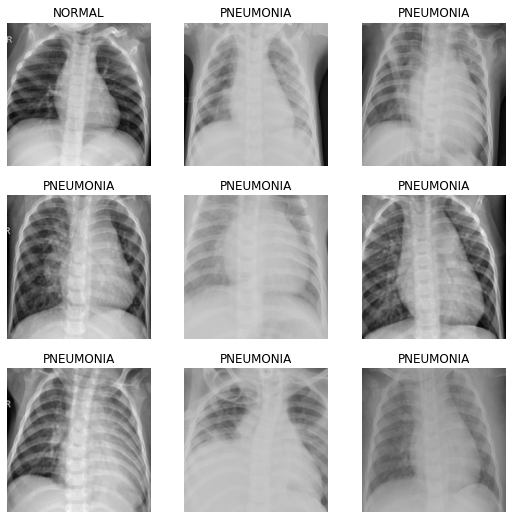

In [3]:
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Zoom()]
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    get_items=get_image_files,
    item_tfms=Resize(512, method="squish"),
    batch_tfms=augs).dataloaders(path)
dls.show_batch()

## Baseline

## Find the optimal learning rate

Minimum/10: 1.45e-02, steepest point: 6.31e-07


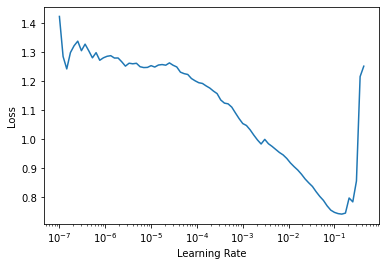

In [6]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [7]:
learn.fit_one_cycle(10, 1.45e-02)

epoch,train_loss,valid_loss,error_rate,time
0,0.321112,0.561772,0.128125,00:30
1,0.167437,0.709780,0.167187,00:30
2,0.169992,0.473649,0.114063,00:30
3,0.126312,0.259274,0.093750,00:30
4,0.085129,0.383895,0.078125,00:30
5,0.081321,0.289605,0.082813,00:30
6,0.067183,0.236146,0.067188,00:30
7,0.050105,0.441230,0.123438,00:29
8,0.037222,0.272316,0.079687,00:29
9,0.029617,0.224404,0.071875,00:29


>Peak accuracy was around 93%, which is very good for a base line model! 

# Fine Tune

## Increase Batch Size
## Since we are going to use transfer learning, normalising the independent variables will help speed up the learning process

In [14]:
augs = [RandomResizedCropGPU(size=224, min_scale=0.75), Zoom(), Normalize]
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=GrandparentSplitter(train_name='train', valid_name='val'),
    get_y=parent_label,
    get_items=get_image_files,
    item_tfms=Resize(512, method="squish"),
    batch_tfms=augs)

In [15]:
dls = dblock.dataloaders(path, bs = 128)

## Add more metrics - false negative rate, accuracy
## Use larger pre-trained model for transfer learning, use mixed-precision training to speed up the learning process

Minimum/10: 1.45e-02, steepest point: 1.32e-06


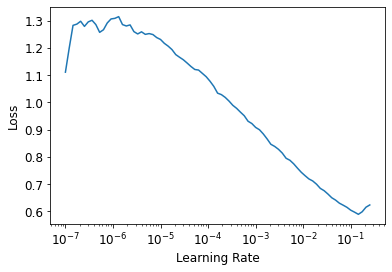

In [25]:
metrics = [accuracy, Recall()]
learn = cnn_learner(dls, resnet50, metrics=metrics).to_fp16()
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

## Train the last layer only

In [20]:
learn.fit_one_cycle(3, lr_min)

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.311834,0.488793,0.798437,0.982412,00:53
1,0.183661,0.391993,0.900000,0.886935,00:54
2,0.108542,0.346198,0.901563,0.987437,00:53


>Larger pre-trained model definitely seemed to help. The accuracy is already at 90% with just 3 epochs. Furthermore, there's also very little false negatives, which is exactly what we want.

## Unfreeze and check for new optimal learning rate 
## The shape is no longer a declining curve since the model is already pretty good at predicting for pneumonia

Minimum/10: 1.58e-05, steepest point: 9.12e-07


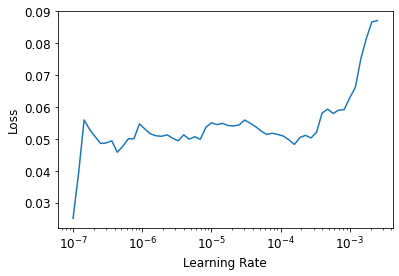

In [21]:
learn.unfreeze()
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

## Train a few more epochs on all the layers with the new learning rate

In [22]:
learn.fit_one_cycle(6, lr_max=lr_min)

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.050553,0.285295,0.912500,0.987437,04:21
1,0.050196,0.264450,0.928125,0.969849,04:21
2,0.037522,0.287709,0.917188,0.982412,04:21
3,0.033541,0.366246,0.898438,0.989950,04:20
4,0.030091,0.501411,0.871875,0.992462,04:22
5,0.028524,0.342847,0.903125,0.987437,04:21


Things were going great until the thrid epoch. Let's see if we can make it better. Also, the training time is getting long. Let's try to shorten that. 
## I'll try using a smaller pre-trained model

In [33]:
metrics = [accuracy, Recall()]
learn = cnn_learner(dls, resnet34, metrics = [accuracy, Recall()]).to_fp16()

Minimum/10: 2.09e-02, steepest point: 5.75e-04


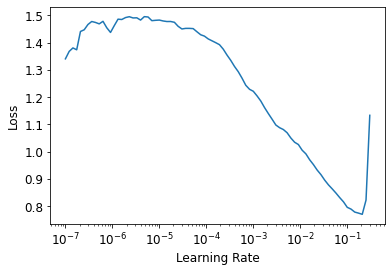

In [34]:
metrics = [accuracy, Recall()]
learn = cnn_learner(dls, resnet34, metrics = [accuracy, Recall()]).to_fp16()
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [35]:
learn.fit_one_cycle(3, lr_min)

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.329602,0.558789,0.871875,0.917085,00:37
1,0.183179,0.264101,0.909375,0.939698,00:37
2,0.105978,0.381433,0.903125,0.994975,00:38


SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=2.75422871709452e-06)

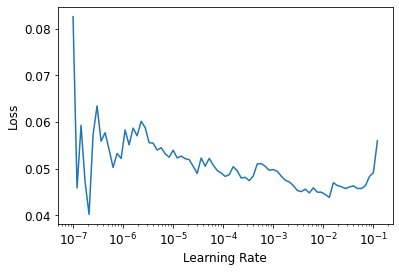

In [36]:
learn.unfreeze()
learn.lr_find()

In [37]:
learn.fit_one_cycle(6, lr_max = slice(5e-4, 5e-02))

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.052026,0.449709,0.871875,0.992462,01:33
1,0.056764,0.243205,0.931250,0.967337,01:36
2,0.042487,0.592872,0.848437,1.000000,01:37
3,0.032875,0.490297,0.871875,0.997487,01:37
4,0.026186,0.355722,0.895312,0.992462,01:37
5,0.019354,0.321987,0.909375,0.992462,01:38


SuggestedLRs(lr_min=0.025118863582611083, lr_steep=6.309573450380412e-07)

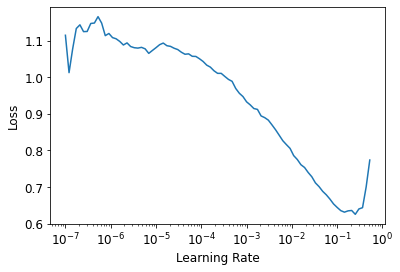

In [40]:
metrics = [accuracy, Recall()]
learn = cnn_learner(dls, resnet18, metrics = [accuracy, Recall()])
learn.lr_find()

In [41]:
learn.fit_one_cycle(3, 0.025118863582611083)

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.306405,0.526436,0.879687,1.000000,00:34
1,0.186731,0.621400,0.885938,0.997487,00:34
2,0.117739,0.483233,0.887500,0.997487,00:34


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=4.786300905834651e-06)

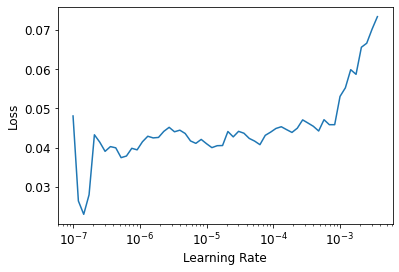

In [43]:
learn.unfreeze()
learn.lr_find()

In [44]:
learn.fit_one_cycle(12, lr_max = slice(1e-5, 6e-03))

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.049820,0.488779,0.871875,0.997487,00:35
1,0.053447,1.148814,0.801562,1.000000,00:36
2,0.055122,0.435267,0.890625,0.994975,00:35
3,0.053092,0.941117,0.775000,1.000000,00:37
4,0.043743,0.315104,0.921875,0.992462,00:35
5,0.041117,0.666819,0.851562,1.000000,00:36
6,0.031745,0.582518,0.864062,0.997487,00:35
7,0.022479,0.510034,0.898438,0.994975,00:35
8,0.020237,0.389530,0.904688,0.997487,00:35
9,0.014138,0.409588,0.914062,0.994975,00:35


In [46]:
learn.fit_one_cycle(12, lr_max = slice(1e-6, 6e-04))

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.005171,0.470155,0.906250,0.994975,00:36
1,0.005871,0.409412,0.918750,0.989950,00:35
2,0.010531,0.336533,0.926562,0.984925,00:35
3,0.010776,0.722409,0.871875,1.000000,00:36
4,0.009534,0.437714,0.906250,0.992462,00:36
5,0.006039,0.483484,0.910937,0.994975,00:35
6,0.003838,0.472838,0.914062,0.994975,00:35
7,0.004210,0.388704,0.915625,0.984925,00:35
8,0.003756,0.839496,0.871875,1.000000,00:35
9,0.002811,0.426431,0.915625,0.987437,00:36


## Can't seem to improve the model any futher,
# Let's see how the training and validation loss changed

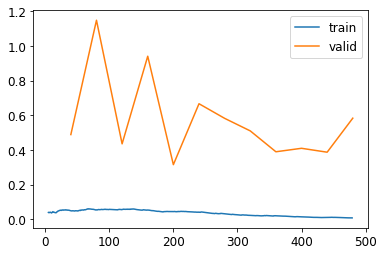

In [45]:
learn.recorder.plot_loss()

>

## Let's try another technique called tta - test time augmentation. 
tta - During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.
> Note: it does not increase training time, but does slow down inference.

In [47]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.909375011920929

No luck with this method either

## One more technique to try training with: progressive resizing
Let's try increasing the size of the images during the last few epochs to help the model learn more sophisticated patterns

In [49]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(512),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [50]:
learn.dls = get_dls(64, 360)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.424602,0.157692,0.947908,0.943914,00:50


epoch,train_loss,valid_loss,accuracy,recall_score,time
0,0.160263,0.107533,0.959863,0.965394,01:00
1,0.126584,0.092100,0.964987,0.966587,01:01
2,0.095975,0.095159,0.964133,0.964200,01:02
3,0.085875,0.085704,0.968403,0.968974,01:02
4,0.087356,0.096169,0.962425,0.960621,01:02


Wow progressive resizing really helped! It's achieveing 96% accuracy.

Shall try round 2 of progressive resizing

In [ ]:
learn.dls = get_dls(32, 512)
learn.fine_tune(5, 1e-3)

Let's print out the final score

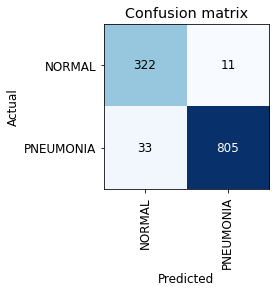

In [51]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

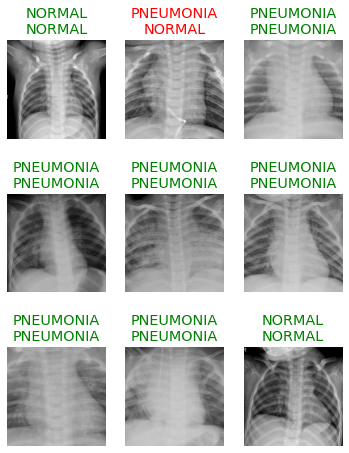

In [52]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

In [ ]:
dd

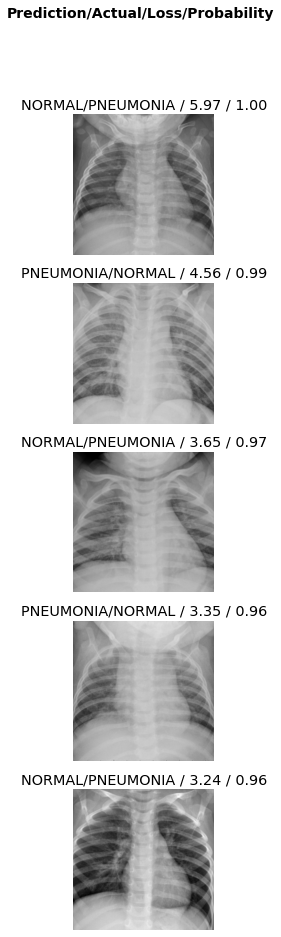

In [58]:
interp.plot_top_losses(5, nrows=5)

### Insight
I were able to achieve an accuracy of 96%. Which is pretty much state-of-the-art results. For that I are very happy.

In the future, I'll try to penalise on false negatives, which have detrimental effects in the real life.

## Making a widget

In [61]:
learn.export()

In [2]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [3]:
learn_inf = load_learner(path/'export.pkl')

In [4]:
learn_inf.predict("/notebooks/storage/xray_pneumonia/chest_xray/val/NORMAL/IM-0001-0001.jpeg")

('NORMAL', tensor(0), tensor([9.9971e-01, 2.9285e-04]))

In [5]:
learn_inf.dls.vocab

['NORMAL', 'PNEUMONIA']

In [8]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [9]:
btn_run = widgets.Button(description='Classify')
btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()
VBox([widgets.Label('pneumonia'), 
      btn_upload, btn_run, out_pl, lbl_pred])